In [7]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import copy
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

pass

In [40]:
super_results[0]

{'amplitude': 14.068080991595963,
 'offset': 0.43537401811905363,
 'duration': 16.566149370165565,
 'fidelity': 0.9862280625625871,
 'end_early': False,
 'iterations': 35}

In [103]:
# Start with a pulse data from landscapes/FlatTop
# data selected so that we start on first fringe

# Need to generate plot and look for abrupt changes in duration or fidelity
# Generate fidelity landscapes at those changes to determine where the fringe is
# Rerun with manually set initial conditions

#amplitude 7.034040495797981 duration 146.17831127951132 offset 0.10188603062894215 fidelity 0.9963395703564574

initial_duration = 146.17831127951132
initial_offset = 0.10188603062894215
initial_amplitude = 7.034040495797981
final_amplitude = initial_amplitude/2
fidelity_threshold = 0.99
ramp_coef = 0.5
cut_factor = 3

def cost(parameters, constants):
    global last_offset, last_duration
    duration = parameters[0]
    offset = parameters[1]
    amplitude = constants[0]
    freq = system.first_energy_spacing/3 - offset
    tlist = np.arange(0, duration, (2*np.pi)/(freq*20))
    tukey.setup(amplitude, freq, ramp_coef, tlist)
    s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.starting_state, pbar=False)
    fidelity = expv.expectation_value(s.final_state, system.target_state)
    # graph.graph_solution(s, system)
    if fidelity > fidelity_threshold:
        results.append({
            "amplitude": amplitude,
            "offset": offset,
            "duration": duration,
            "fidelity": fidelity,
            "end_early": True
        })
        last_duration = duration
        last_offset = offset
        print("amplitude", amplitude, "duration", duration, "offset", offset, "fidelity", fidelity)
        raise RuntimeError

    return (1 - fidelity)

last_duration = initial_duration
last_offset = initial_offset
results = []
for amplitude in tqdm(np.linspace(initial_amplitude, final_amplitude, 50)):
    try:
        result = scipy.optimize.minimize(cost, [last_duration, last_offset], [amplitude], method="Nelder-Mead", options={"disp":True})
        results.append({
            "amplitude": amplitude,
            "offset": result.x[1],
            "duration": result.x[0],
            "fidelity": 1-result.fun,
            "end_early": False,
            "iterations": result.nit
        })
        last_duration = result.x[0]
        last_offset = result.x[1]
    except:
        print("ended early!")


  2%|▏         | 1/50 [00:06<04:57,  6.07s/it]

amplitude 7.034040495797981 duration 146.17831127951132 offset 0.10188603062894215 fidelity 0.9963395703564574
ended early!


  4%|▍         | 2/50 [00:37<16:47, 21.00s/it]

amplitude 6.962264572371471 duration 151.659997952493 offset 0.0993388798632186 fidelity 0.9922760628270304
ended early!


  6%|▌         | 3/50 [01:23<25:31, 32.58s/it]

amplitude 6.890488648944961 duration 161.6126853181254 offset 0.09747627586578325 fidelity 0.9960706838840188
ended early!


  8%|▊         | 4/50 [02:22<32:51, 42.85s/it]

amplitude 6.818712725518451 duration 162.62276460136368 offset 0.09625782241746098 fidelity 0.9982088420046504
ended early!


 10%|█         | 5/50 [03:03<31:32, 42.05s/it]

amplitude 6.746936802091941 duration 168.72111827391484 offset 0.09385137685702447 fidelity 0.9991423104651656
ended early!


 12%|█▏        | 6/50 [03:36<28:33, 38.94s/it]

amplitude 6.675160878665431 duration 175.04816020918668 offset 0.09150509243559884 fidelity 0.9975547562728462
ended early!


 14%|█▍        | 7/50 [04:15<28:04, 39.18s/it]

amplitude 6.603384955238921 duration 181.61246621703123 offset 0.08921746512470888 fidelity 0.9937388044152861
ended early!


 16%|█▌        | 8/50 [05:22<33:33, 47.94s/it]

amplitude 6.531609031812412 duration 191.82816744173925 offset 0.08810224681065001 fidelity 0.9994686553962282
ended early!


 18%|█▊        | 9/50 [06:01<30:49, 45.12s/it]

amplitude 6.459833108385901 duration 199.0217237208045 offset 0.08589969064038375 fidelity 0.9996082728880175
ended early!


 20%|██        | 10/50 [06:46<30:00, 45.01s/it]

amplitude 6.388057184959392 duration 206.48503836033467 offset 0.08375219837437417 fidelity 0.998209011724829
ended early!


 22%|██▏       | 11/50 [07:23<27:39, 42.55s/it]

amplitude 6.316281261532882 duration 214.22822729884723 offset 0.0816583934150148 fidelity 0.9956124908943786
ended early!


 24%|██▍       | 12/50 [07:59<25:42, 40.58s/it]

amplitude 6.2445053381063715 duration 222.261785822554 offset 0.07961693357963942 fidelity 0.9921556952606654
ended early!


 26%|██▌       | 13/50 [09:07<30:12, 48.97s/it]

amplitude 6.1727294146798615 duration 223.65092198394495 offset 0.07862172190989393 fidelity 0.9982399756968772
ended early!


 28%|██▊       | 14/50 [10:25<34:45, 57.92s/it]

amplitude 6.100953491253351 duration 226.44655850874426 offset 0.07665617886214658 fidelity 0.9965002585016317
ended early!


 30%|███       | 15/50 [11:41<36:49, 63.13s/it]

amplitude 6.029177567826841 duration 239.18417742486113 offset 0.07497932494953713 fidelity 0.9972958495910994
ended early!


 32%|███▏      | 16/50 [12:53<37:16, 65.79s/it]

amplitude 5.957401644400331 duration 242.1739796426719 offset 0.0731048418257987 fidelity 0.9946723752851642
ended early!


 34%|███▍      | 17/50 [13:58<36:04, 65.59s/it]

amplitude 5.885625720973821 duration 257.3098533703389 offset 0.07127722078015372 fidelity 0.9983234694114042
ended early!


 36%|███▌      | 18/50 [15:18<37:22, 70.08s/it]

amplitude 5.813849797547311 duration 260.5262265374681 offset 0.06949529026064988 fidelity 0.9947962816386678
ended early!


 38%|███▊      | 19/50 [16:30<36:25, 70.50s/it]

amplitude 5.742073874120801 duration 276.80911569605985 offset 0.06775790800413363 fidelity 0.9981891218730201
ended early!


 40%|████      | 20/50 [17:50<36:44, 73.49s/it]

amplitude 5.670297950694291 duration 294.1096854270636 offset 0.06606396030403028 fidelity 0.9993814066991753
ended early!


 42%|████▏     | 21/50 [19:24<38:26, 79.54s/it]

amplitude 5.598522027267781 duration 297.7860564949019 offset 0.06441236129642952 fidelity 0.9969927868231409
ended early!


 44%|████▍     | 22/50 [21:15<41:33, 89.05s/it]

amplitude 5.526746103841271 duration 301.5083822010882 offset 0.06280205226401878 fidelity 0.9910946031910273
ended early!


 46%|████▌     | 23/50 [22:56<41:39, 92.58s/it]

amplitude 5.454970180414762 duration 320.3526560886562 offset 0.061232000957418306 fidelity 0.9935480874160862
ended early!


 48%|████▊     | 24/50 [24:40<41:32, 95.88s/it]

amplitude 5.383194256988251 duration 340.3746970941972 offset 0.059701200933482856 fidelity 0.9932206538696521
ended early!


 50%|█████     | 25/50 [27:13<47:08, 113.14s/it]

amplitude 5.3114183335617415 duration 355.2660900920683 offset 0.057462405898477245 fidelity 0.9962285276761198
ended early!


 52%|█████▏    | 26/50 [28:14<39:02, 97.60s/it] 

amplitude 5.239642410135231 duration 368.58856847052084 offset 0.056025845751015324 fidelity 0.9982186242387591
ended early!


 54%|█████▍    | 27/50 [30:43<43:16, 112.90s/it]

amplitude 5.167866486708721 duration 384.138398702871 offset 0.05423126787930311 fidelity 0.9914041647929871
ended early!


 56%|█████▌    | 28/50 [32:03<37:49, 103.14s/it]

amplitude 5.096090563282211 duration 398.54358865422864 offset 0.05287548618232053 fidelity 0.9958657424575156
ended early!


 58%|█████▊    | 29/50 [33:49<36:20, 103.85s/it]

amplitude 5.024314639855701 duration 413.48897322876223 offset 0.05155359902776253 fidelity 0.9972277710970958
ended early!


 60%|██████    | 30/50 [36:50<42:23, 127.19s/it]

amplitude 4.952538716429191 duration 439.3320340555599 offset 0.05026475905206847 fidelity 0.9972557385449218
ended early!


 62%|██████▏   | 31/50 [41:59<57:32, 181.71s/it]

amplitude 4.880762793002681 duration 458.5528105454906 offset 0.048379830587615885 fidelity 0.9938107939089603
ended early!


 64%|██████▍   | 32/50 [43:32<46:31, 155.09s/it]

amplitude 4.808986869576171 duration 475.7485409409465 offset 0.047170334822925486 fidelity 0.9978658303828435
ended early!


 66%|██████▌   | 33/50 [48:50<57:48, 204.03s/it]

amplitude 4.737210946149661 duration 505.48282474975576 offset 0.045991076452352356 fidelity 0.9958559931268047
ended early!


 68%|██████▊   | 34/50 [52:59<57:58, 217.42s/it]

amplitude 4.665435022723151 duration 527.5976983325576 offset 0.044266411085389146 fidelity 0.997233311865428
ended early!


 70%|███████   | 35/50 [55:43<50:21, 201.42s/it]

amplitude 4.593659099296641 duration 534.1926695617146 offset 0.04315975080825442 fidelity 0.991359940769121
ended early!


 72%|███████▏  | 36/50 [59:39<49:22, 211.58s/it]

amplitude 4.521883175870131 duration 557.5635988550397 offset 0.041541260152944876 fidelity 0.9901656642935953
ended early!


 74%|███████▍  | 37/50 [1:02:11<41:58, 193.70s/it]

amplitude 4.450107252443621 duration 592.4113237834797 offset 0.04050272864912125 fidelity 0.9917087619995244
ended early!


 76%|███████▌  | 38/50 [1:06:30<42:42, 213.56s/it]

amplitude 4.3783313290171115 duration 618.329319199007 offset 0.038983876324779204 fidelity 0.9924404733468206
ended early!


 78%|███████▊  | 39/50 [1:11:57<45:23, 247.58s/it]

amplitude 4.306555405590601 duration 687.8913676088952 offset 0.0380092794166597 fidelity 0.9915161661907189
ended early!


 80%|████████  | 40/50 [1:15:47<40:21, 242.18s/it]

amplitude 4.234779482164091 duration 700.7893307515619 offset 0.03658393143853496 fidelity 0.9964427938764748
ended early!


 82%|████████▏ | 41/50 [1:20:34<38:19, 255.51s/it]

amplitude 4.16300355873758 duration 731.4488639719427 offset 0.0352120340095899 fidelity 0.9948886252690124
ended early!


 84%|████████▍ | 42/50 [1:27:00<39:18, 294.75s/it]

amplitude 4.091227635311071 duration 800.0221949693125 offset 0.03389158273423027 fidelity 0.9925770522701911
ended early!


 86%|████████▌ | 43/50 [1:33:47<38:18, 328.37s/it]

amplitude 4.01945171188456 duration 850.0235821548947 offset 0.03304429316587451 fidelity 0.9930709572176301
ended early!


 88%|████████▊ | 44/50 [1:40:08<34:24, 344.11s/it]

amplitude 3.9476757884580507 duration 865.9615243202991 offset 0.03180513217215422 fidelity 0.9935648176149676
ended early!


 90%|█████████ | 45/50 [1:43:28<25:05, 301.01s/it]

amplitude 3.875899865031541 duration 925.4963791173197 offset 0.030612439715698436 fidelity 0.9969054910263596
ended early!


 92%|█████████▏| 46/50 [1:49:42<21:32, 323.03s/it]

amplitude 3.804123941605031 duration 989.1242551816356 offset 0.02946447322635974 fidelity 0.998492378180575
ended early!


 94%|█████████▍| 47/50 [1:53:23<14:37, 292.36s/it]

amplitude 3.732348018178521 duration 1007.6703349662912 offset 0.02835955548037125 fidelity 0.9913461425620247
ended early!


 96%|█████████▌| 48/50 [2:04:49<13:40, 410.28s/it]

amplitude 3.660572094752011 duration 1076.9476704952237 offset 0.027296072149857326 fidelity 0.9919090290477894
ended early!


 98%|█████████▊| 49/50 [2:35:24<13:57, 837.76s/it]

amplitude 3.5887961713255008 duration 1181.2769760744486 offset 0.026101868993301067 fidelity 0.9966033642600481
ended early!


100%|██████████| 50/50 [2:41:46<00:00, 194.13s/it]

amplitude 3.5170202478989907 duration 1239.417952240613 offset 0.025082264735750245 fidelity 0.9960892987513901
ended early!


In [110]:
fids = []
durs = []
offs = []
amps = []

for o in super_results:
    amps.append(o["amplitude"])
    durs.append(o["duration"])
    offs.append(o["offset"])
    fids.append(o["fidelity"])

In [108]:
# saver.save(results, "params_as_function_of_amplitude_Nov18")
import dill
def load_via_dill(name):
    name = "../save_data/" + name + ".dill"
    with open(name, "rb") as f:
        return dill.load(f)
first_results = load_via_dill("Nov19_params_as_function_of_amplitude")
second_results = load_via_dill("Nov19_#2_params_as_function_of_amplitude")
third_results = load_via_dill("Nov19_#3_params_as_function_of_amplitude")
fourth_results = load_via_dill("Nov19_#4_params_as_function_of_amplitude")

In [109]:
super_results = list(np.flip(fourth_results)) + list(np.flip(third_results)) + list(np.flip(first_results)) + second_results

In [106]:
saver.save(results, "Nov19_#4_params_as_function_of_amplitude")

In [134]:
# pick a point to graph
i = 150
p_amp = amps[i]
p_dur = durs[i]
p_off = offs[i]
p_fid = fids[i]

p_amp, p_dur, p_off, p_fid

(20.326941514387634, 5.753297546728568, 0.8483327920214545, 0.7194502382738384)

In [75]:
system.first_energy_spacing/3 - p_off

8.182308822749473

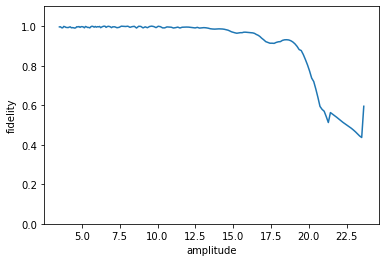

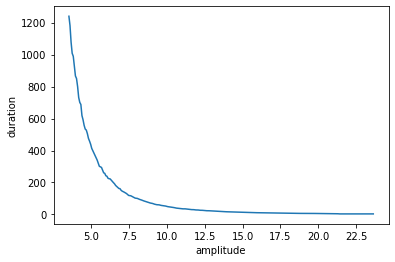

In [111]:
plt.plot(amps, fids)
plt.ylim((0, 1.1))
plt.xlabel("amplitude")
plt.ylabel("fidelity")
plt.show()
plt.plot(amps, durs)
plt.xlabel("amplitude")
plt.ylabel("duration")
plt.show()

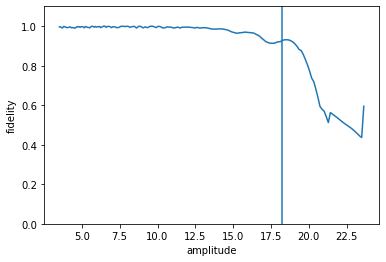

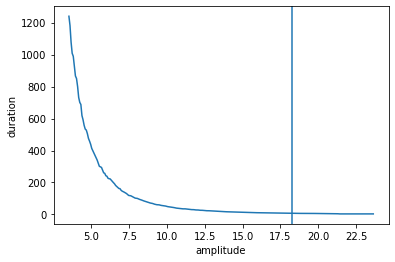

In [122]:
plt.plot(amps, fids)
plt.ylim((0, 1.1))
plt.xlabel("amplitude")
plt.ylabel("fidelity")
plt.axvline(p_amp)
plt.show()
plt.plot(amps, durs)
plt.xlabel("amplitude")
plt.ylabel("duration")
plt.axvline(p_amp)
plt.show()

10.3%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.18s. Est. time left: 00:00:00:00
30.3%. Run time:   0.27s. Est. time left: 00:00:00:00
40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.3%. Run time:   0.35s. Est. time left: 00:00:00:00
60.0%. Run time:   0.43s. Est. time left: 00:00:00:00
70.3%. Run time:   0.48s. Est. time left: 00:00:00:00
80.0%. Run time:   0.53s. Est. time left: 00:00:00:00
90.3%. Run time:   0.58s. Est. time left: 00:00:00:00
Total run time:   0.61s
0.9279761353583663 0.9279761353583663


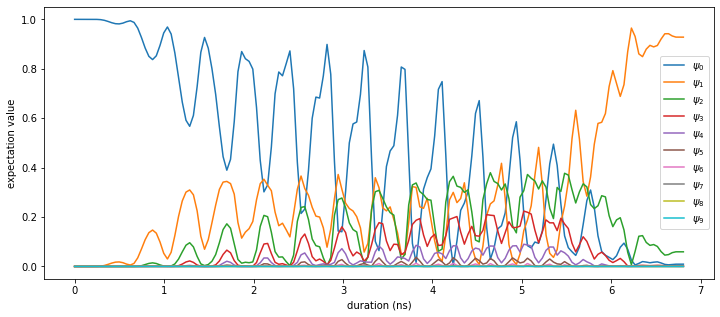

In [123]:
freq = system.first_energy_spacing/3 - p_off
tlist = np.arange(0, p_dur, (2*np.pi)/(freq*20))
tukey.setup(p_amp, freq, ramp_coef, tlist)
s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.starting_state, pbar=True)
fidelity = expv.expectation_value(s.final_state, system.target_state)
print(fidelity, p_fid)
graph.graph_solution(s, system)

14.068080991595963

In [29]:
t_multiplier = 5
amplitude = 10
freq = 8
ramp_slope = 0.5

def inner(dur):
    tlist = np.linspace(0, dur, int(dur*t_multiplier))
    tukey.setup(amplitude=amplitude, drive_frequency=freq, ramp_coef=ramp_slope, tlist=tlist)
    s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(_amplitude, _ramp_slope, freq_list, dur_list, _t_multiplier=5, skip_rate=1):
    global t_multiplier, amplitude, freq, ramp_slope
    t_multiplier = _t_multiplier
    amplitude = _amplitude
    ramp_slope = _ramp_slope
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        freq = f
        fids.append(parallel_map(inner, dur_points))

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (GHz)")
    plt.ylabel("duration (ns)")
    
    return fids

100%|██████████| 50/50 [27:04<00:00, 32.49s/it]


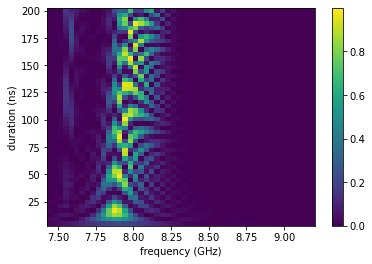

In [32]:
# for i = 0
freq_list = np.linspace(system.first_energy_spacing/3 - p_off*2, system.first_energy_spacing/3 + p_off*2, 50)
fids0 = generate_fidelity_landscape(p_amp, 0.5, freq_list, np.linspace(5, 200, 50))

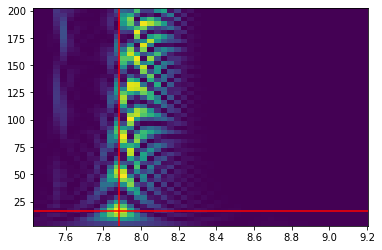

In [39]:
plt.pcolormesh(freq_list, np.linspace(5, 200, 50), fids0, shading="auto")
plt.axhline(p_dur, color="red")
plt.axvline(system.first_energy_spacing/3 - p_off, color="red")

100%|██████████| 40/40 [37:26<00:00, 56.16s/it]


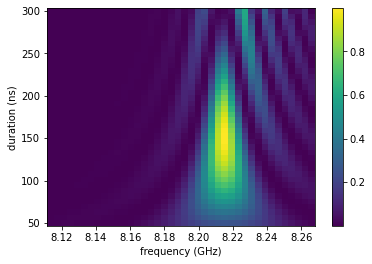

In [53]:
# for low amp
freq_list = np.linspace((system.first_energy_spacing/3 - p_off/2), system.first_energy_spacing/3 - p_off*2, 40)
fids_low_amp = generate_fidelity_landscape(p_amp, 0.5, freq_list, np.linspace(50, 300, 40))

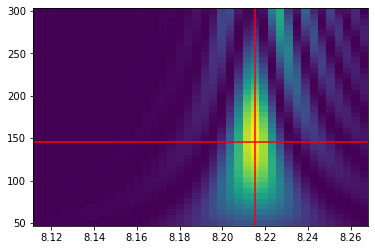

In [65]:
plt.pcolormesh(np.flip(freq_list), np.linspace(50, 300, 40), fids_low_amp, shading="auto")
plt.axhline(p_dur, color="red")
plt.axvline(system.first_energy_spacing/3 - p_off, color="red")

100%|██████████| 40/40 [12:10<00:00, 18.27s/it]


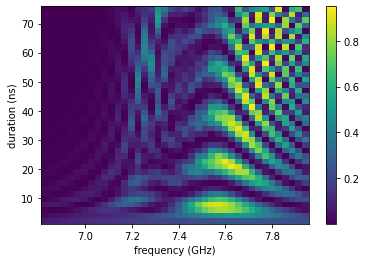

In [129]:
# for edge of decent amps
# i = 135
freq_list = np.linspace((system.first_energy_spacing/3 - p_off/2), system.first_energy_spacing/3 - p_off*2, 40)
fids_edge_amp = generate_fidelity_landscape(p_amp, 0.5, freq_list, np.linspace(2, 75, 40))

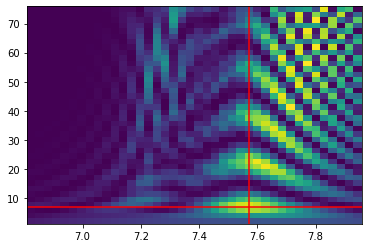

In [131]:
plt.pcolormesh(np.flip(freq_list), np.linspace(2, 75, 40), fids_edge_amp, shading="auto")
plt.axhline(p_dur, color="red")
plt.axvline(system.first_energy_spacing/3 - p_off, color="red")

100%|██████████| 40/40 [09:18<00:00, 13.97s/it]


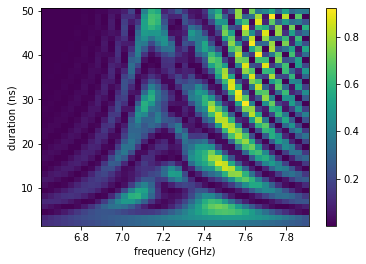

In [135]:
# for deep outside the decent amps
# i = 150
freq_list = np.linspace((system.first_energy_spacing/3 - p_off/2), system.first_energy_spacing/3 - p_off*2, 40)
fids_deep_amp = generate_fidelity_landscape(p_amp, 0.5, freq_list, np.linspace(2, 50, 40))

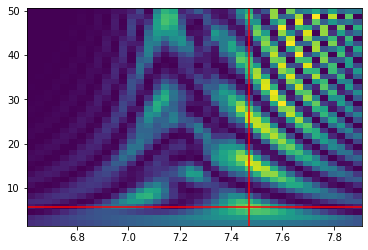

In [136]:
plt.pcolormesh(np.flip(freq_list), np.linspace(2, 50, 40), fids_deep_amp, shading="auto")
plt.axhline(p_dur, color="red")
plt.axvline(system.first_energy_spacing/3 - p_off, color="red")